In [284]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


### Imports

In [285]:
import pandas as pd
import lightgbm as lgbm
import os

### Importing Preprocessed Data

In [286]:
loc_pre = os.getenv("LOC_PRE")
loc_pre_train = f"{loc_pre}/train.csv"

In [287]:
df_train = pd.read_csv(loc_pre_train)
df_train.head(5)

,sales,store_nbr,family,onpromotion,year,month,day
0,0.0,1,AUTOMOTIVE,0,2013,1,1
1,0.0,1,BABY CARE,0,2013,1,1
2,0.0,1,BEAUTY,0,2013,1,1
3,0.0,1,BEVERAGES,0,2013,1,1
4,0.0,1,BOOKS,0,2013,1,1


In [288]:
cat_cols = [name for name,type in df_train.dtypes.items() if type=="object"]
cat_cols

['family']

In [289]:
for col in cat_cols:
    df_train[col] = df_train[col].astype("category")


### Splitting Train/Validation Data

In [290]:
def split_df(df:pd.DataFrame,test_pct:int=0.3):
    cnt = int(len(df)*test_pct)
    return df[:-cnt],df[-cnt:]

In [291]:
train,val = split_df(df_train)
train.shape,val.shape

((2100622, 7), (900266, 7))

In [292]:
lgb_train = lgbm.Dataset(train.iloc[:,1:],train.iloc[:,0])
lgb_val = lgbm.Dataset(val.iloc[:,1:],val.iloc[:,0],reference=lgb_train)

In [293]:
lgb_train.get_label()

0             0.000
1             0.000
2             0.000
3             0.000
4             0.000
             ...   
2100617      10.000
2100618    8885.000
2100619       0.000
2100620    1374.956
2100621      32.000
Name: sales, Length: 2100622, dtype: float64

In [294]:
params = {
    "objective": "rmse",
    "n_estimators":300,
    "learning_rate":0.1
}

In [295]:
eval_results={}

In [296]:
model = lgbm.train(
    params,
    lgb_train,
    valid_sets=[lgb_train,lgb_val],
    valid_names=["train","valid"],
    callbacks=[lgbm.record_evaluation(eval_results)],
)

/mnt/d/Work/03-Projects/06-Repos/kaggle-store-sales/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 2100622, number of used features: 6
[LightGBM] [Info] Start training from score 312.805461


/mnt/d/Work/03-Projects/06-Repos/kaggle-store-sales/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/mnt/d/Work/03-Projects/06-Repos/kaggle-store-sales/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


### Performance

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

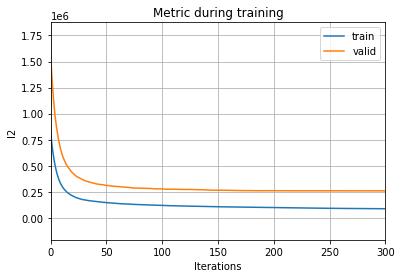

In [297]:
lgbm.plot_metric(eval_results)

In [298]:
eval_results["train"]["l2"][-1]
# l2 loss with day, month, and year time steps: 118983.70518049951
# l2 loss with n_estimators=3000, learningrate = 0.1: 36724.93942673205

86976.82559871639

In [299]:
eval_results["valid"]["l2"][-1]
# l2 loss with day, month, and year time steps: 277458.55905733566
# l2 loss with n_estimators=3000, learningrate = 0.1: 350617.34411903867

258676.92421523485

In [300]:
# the closer to zero the better
(eval_results["valid"]["l2"][-1] -  eval_results["train"]["l2"][-1])/eval_results["valid"]["l2"][-1]

0.6637627192198002

In [301]:
model.save_model("lgbm.pkl")